In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.signal import savgol_filter
import joblib
import os


In [2]:
# Load and preprocess data
df = pd.read_csv('Fill-1.csv')
x = np.array(df.iloc[:, :2])
y = np.array(df.iloc[:, 2])

scaler_x = StandardScaler()
x = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y = y.reshape(-1, 1)  # Reshape y to have one feature
y = scaler_y.fit_transform(y)

x = torch.from_numpy(x).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=666)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=512)


In [3]:
# Define the RNN model
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output=1):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.linear(out)
        return out

# Instantiate the model
model = Net(hidden_dim=220, input_size=1, num_layers=2)


In [4]:
# Load the model
model_path = './rnnmodel/model_rnn_weight.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Model loaded from disk.")
else:
    print("Model file not found.")


Model loaded from disk.


In [5]:
# Freeze only the first RNN layer
for name, param in model.rnn.named_parameters():
    if "l0" in name:  # 只冻结第一个 RNN 层的参数
        param.requires_grad = False


In [6]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()


In [8]:
train_loss_list = []
val_loss_list = []
train_mae_list = []
val_mae_list = []

model.train()
for i in range(50):  # Fine-tune for fewer epochs
    train_loss = 0
    train_mae = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.reshape(-1, 2, 1)
        outputs = model(data)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Calculate MAE
        train_mae += mean_absolute_error(label.detach().numpy(), outputs.detach().numpy())

    train_loss /= len(train_loader)
    train_mae /= len(train_loader)
    train_loss_list.append(train_loss)
    train_mae_list.append(train_mae)

    # Validation loss and MAE
    model.eval()
    val_loss = 0
    val_mae = 0  # Initialize val_mae at the start of each epoch
    with torch.no_grad():
        for data, label in test_loader:
            data = data.reshape(-1, 2, 1)
            outputs = model(data)
            loss = criterion(outputs, label)
            val_loss += loss.item()
            
            # Calculate MAE
            val_mae += mean_absolute_error(label.numpy(), outputs.numpy())

    val_loss /= len(test_loader)
    val_mae /= len(test_loader)
    val_loss_list.append(val_loss)
    val_mae_list.append(val_mae)

    print(f'Epoch: {i+1}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}, Train MAE: {train_mae:.8f}, Val MAE: {val_mae:.8f}')


Epoch: 1, Train Loss: 0.27563579, Val Loss: 0.10432109, Train MAE: 0.37406005, Val MAE: 0.21349818
Epoch: 2, Train Loss: 0.08384729, Val Loss: 0.07149275, Train MAE: 0.18096116, Val MAE: 0.15748152
Epoch: 3, Train Loss: 0.06717549, Val Loss: 0.06296911, Train MAE: 0.14636515, Val MAE: 0.13389414
Epoch: 4, Train Loss: 0.06170495, Val Loss: 0.05990186, Train MAE: 0.12979809, Val MAE: 0.12448152
Epoch: 5, Train Loss: 0.05964101, Val Loss: 0.05841212, Train MAE: 0.12209081, Val MAE: 0.11715288
Epoch: 6, Train Loss: 0.05848434, Val Loss: 0.05775327, Train MAE: 0.11765386, Val MAE: 0.11479369
Epoch: 7, Train Loss: 0.05779465, Val Loss: 0.05737977, Train MAE: 0.11521766, Val MAE: 0.11342033
Epoch: 8, Train Loss: 0.05706469, Val Loss: 0.05620513, Train MAE: 0.11221219, Val MAE: 0.10940750
Epoch: 9, Train Loss: 0.05670377, Val Loss: 0.05612690, Train MAE: 0.11162591, Val MAE: 0.11217081
Epoch: 10, Train Loss: 0.05612983, Val Loss: 0.05536810, Train MAE: 0.10978792, Val MAE: 0.10740010
Epoch: 11

In [8]:
# Testing the model
model.eval()
test_loss = 0
output = torch.zeros(size=(1, 1))
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        data = data.reshape(-1, 2, 1)
        outputs = model(data)
        output = torch.cat((output, outputs), 0)
        loss = criterion(outputs, label)
        test_loss += loss.item()

test_loss = test_loss / (batch_idx + 1)
print(f'Test MSE: {test_loss:.8f}')

# Remove the initial zero
output = output[1:]

# Inverse transform
output = output.numpy()
y_test = y_test.numpy()
output = scaler_y.inverse_transform(output)
y_test = scaler_y.inverse_transform(y_test)

# Calculate Metrics
mse = mean_squared_error(y_test, output)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, output)
r2 = r2_score(y_test, output)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Test MSE: 0.03990585
Mean Squared Error (MSE): 4.626844882965088
Root Mean Squared Error (RMSE): 2.151010274887085
Mean Absolute Error (MAE): 0.9024297595024109
R² Score: 0.9602341859066506


In [10]:
# Save the fine-tuned model
model_path = './rnntlmodel/model_rnnlt_weight_TL.pth'
torch.save(model.state_dict(), model_path)
print("model saved to disk.")


model saved to disk.


In [7]:
model_path = './rnntlmodel/model_rnnlt_weight_TL.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()  # 切换到评估模式
    print("model loaded from disk.")
else:
    print("Model file not found.")
    

model loaded from disk.


损失图已保存到: tl_rnn_fig/rnn_loss_plot.png
局部放大损失图已保存到: tl_rnn_fig/zoom_loss_plot.png


/tmp/ipykernel_840/1110677021.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


结合图已保存到: tl_rnn_fig/rnn_combined_plot.png


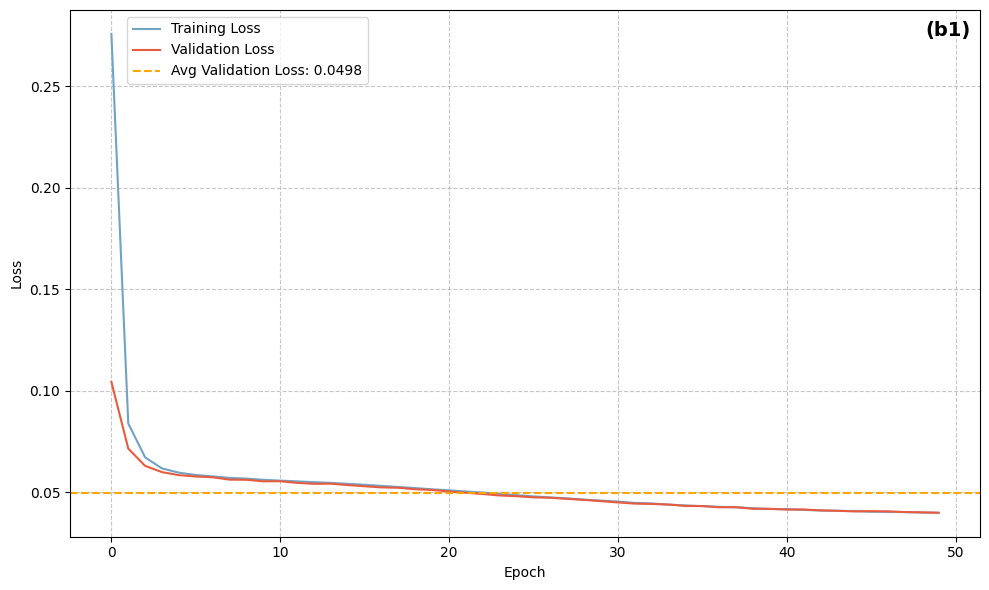

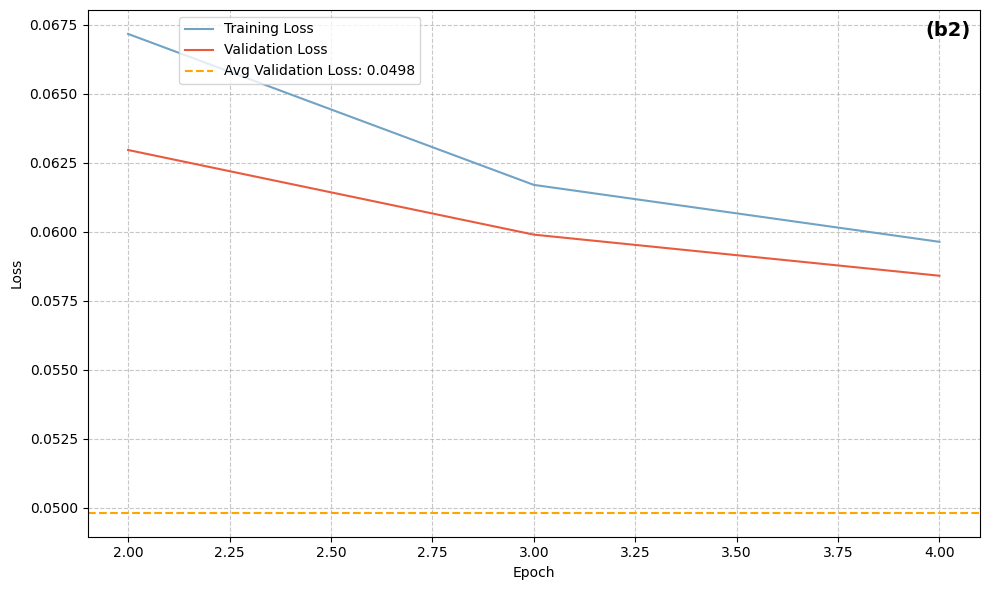

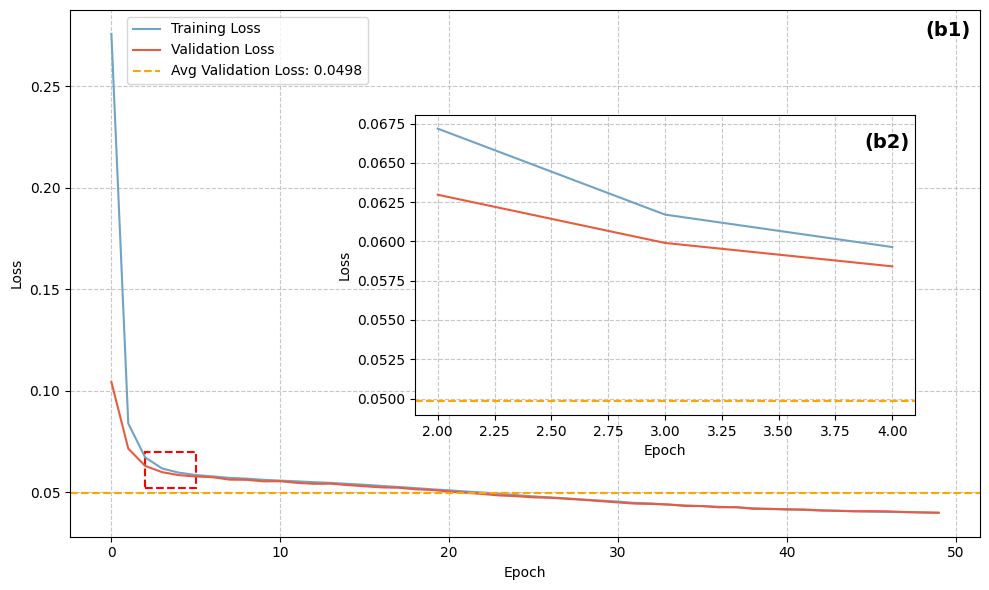

In [23]:
# Calculate average validation loss
avg_val_loss = np.mean(val_loss_list)

# Custom zoom range
zoom_epoch_start = 2
zoom_epoch_end = 5

# Custom rectangle height
rect_y_min = 0.052
rect_y_max = 0.07

# Create folder for saving plots
folder_name = "tl_rnn_fig"
os.makedirs(folder_name, exist_ok=True)


# 绘制损失图
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(b1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
loss_file_path = os.path.join(folder_name, 'rnn_loss_plot.png')
plt.savefig(loss_file_path, dpi=300, bbox_inches='tight')
print(f"损失图已保存到: {loss_file_path}")

# 绘制局部放大图
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4', label='Training Loss')
ax2.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F', label='Validation Loss')
ax2.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax2.legend(loc='upper left', bbox_to_anchor=(0.095, 1), bbox_transform=ax2.transAxes)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.text(0.99, 0.98, '(b2)', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')
plt.tight_layout()
zoom_loss_file_path = os.path.join(folder_name, 'zoom_loss_plot.png')
plt.savefig(zoom_loss_file_path, dpi=300, bbox_inches='tight')
print(f"局部放大损失图已保存到: {zoom_loss_file_path}")

# 绘制结合图，将局部放大图嵌入到主图中
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(train_loss_list, color='#70A3C4', label='Training Loss')
ax1.plot(val_loss_list, color='#E95B3F', label='Validation Loss')
ax1.axhline(y=avg_val_loss, color='#FFA500', linestyle='--', label=f'Avg Validation Loss: {avg_val_loss:.4f}')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left', bbox_to_anchor=(0.055, 1), bbox_transform=ax1.transAxes)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.text(0.99, 0.98, '(b1)', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 嵌入放大损失图
inset_ax = fig.add_axes([0.42, 0.30, 0.5, 0.5])  # [left, bottom, width, height]
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), train_loss_list[zoom_epoch_start:zoom_epoch_end], color='#70A3C4')
inset_ax.plot(range(zoom_epoch_start, zoom_epoch_end), val_loss_list[zoom_epoch_start:zoom_epoch_end], color='#E95B3F')
inset_ax.axhline(y=avg_val_loss, color='#FFA500', linestyle='--')  # 添加平均值线
inset_ax.set_xlabel('Epoch')
inset_ax.set_ylabel('Loss')
inset_ax.grid(True, linestyle='--', alpha=0.7)
inset_ax.text(0.99, 0.94, '(b2)', transform=inset_ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='right')

# 添加红色虚线框
rect = plt.Rectangle((zoom_epoch_start, rect_y_min), 
                     zoom_epoch_end - zoom_epoch_start, 
                     rect_y_max - rect_y_min, 
                     edgecolor='red', linestyle='--', linewidth=1.5, facecolor='none', transform=ax1.transData)
ax1.add_patch(rect)

# 添加标注和链接
ax1.annotate('', xy=(0.6, 0.45), xycoords='axes fraction', xytext=(0.45, 0.25), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=2))

plt.tight_layout()
combined_file_path = os.path.join(folder_name, 'rnn_combined_plot.png')
plt.savefig(combined_file_path, dpi=300, bbox_inches='tight')
print(f"结合图已保存到: {combined_file_path}")

# 显示图表
plt.show()

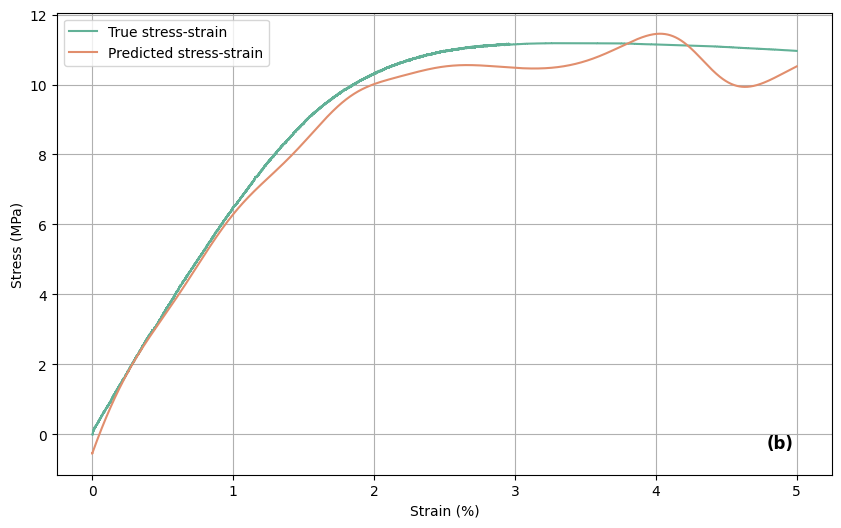

Stress-strain curve saved and displayed: tl_rnn_fig/prediction/stress_strain_curve.png


In [9]:
# Load new data for prediction
file_name = '60-p.csv'
df_new_data = pd.read_csv(file_name)

# Extract features and true values
strain = df_new_data.iloc[:, 1].values  # Assuming the second column is strain
stress_true = df_new_data.iloc[:, 2].values  # Third column is true stress

# Normalize new data
x_new = df_new_data.iloc[:, :2].values
x_new_scaled = scaler_x.transform(x_new)

# Convert to tensor
x_new_tensor = torch.from_numpy(x_new_scaled).type(torch.FloatTensor).reshape(-1, 2, 1)

# Make predictions
with torch.no_grad():
    stress_pred_scaled = model(x_new_tensor).numpy()

# Inverse transform predictions
stress_pred = scaler_y.inverse_transform(stress_pred_scaled).flatten()

# Use a specific strain threshold
strain_threshold =5

valid_indices = strain < strain_threshold
strain_truncated = strain[valid_indices]
stress_true_truncated = stress_true[valid_indices]
stress_pred_truncated = stress_pred[valid_indices]

# Plot true vs predicted stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(strain_truncated, stress_true_truncated, label='True stress-strain', color='#62B197')
plt.plot(strain_truncated, stress_pred_truncated, label='Predicted stress-strain', color='#E18E6D')
plt.xlabel('Strain (%)')
plt.ylabel('Stress (MPa)')
plt.legend()
# plt.title('True vs Predicted Stress-Strain Curve')
plt.grid(True)

# Add text (b1) in the bottom right corner
plt.text(0.95, 0.05, '(b)', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', ha='right', va='bottom')

# Save the plot
folder_path = os.path.join('tl_rnn_fig', 'prediction')
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, 'stress_strain_curve.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Close the plot to free memory
plt.close()

print(f"Stress-strain curve saved and displayed: {save_path}")

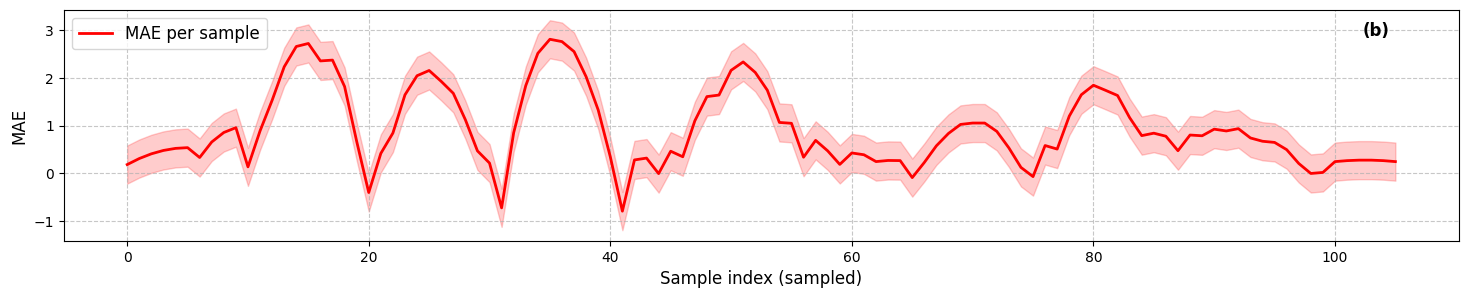

MAE per sample plot saved and displayed: ./tl_rnn_fig/mae_per_sample.png


In [17]:
# 计算每个样本的 MAE
mae_per_sample = np.abs(y_test - output).flatten()

# 采样数据以减少密度（例如，每隔250个点取一个）
sampling_rate = 400
mae_sampled = mae_per_sample[::sampling_rate]

# 确保 window_length 小于或等于数据长度，并且是奇数
window_length = min(11, len(mae_sampled))
if window_length % 2 == 0:
    window_length -= 1

# 如果 window_length 仍然大于数据长度，调整为数据长度的最大奇数
if window_length < 3:
    window_length = 3

# 平滑曲线（使用 Savitzky-Golay 滤波器）
polyorder = 2  # 确保 polyorder 小于 window_length
mae_smoothed = savgol_filter(mae_sampled, window_length, polyorder)

# 绘制 MAE 随时间变化的图
plt.figure(figsize=(18, 3))
plt.plot(mae_smoothed, label='MAE per sample', color='red', linewidth=2)

# 添加跟随曲线变化的窄色条
offset = 0.4  # 设置窄色条的宽度
plt.fill_between(range(len(mae_smoothed)), mae_smoothed - offset, mae_smoothed + offset, color='red', alpha=0.2)

# 设置图例位置为左上角
plt.legend(loc='upper left', fontsize=12)

# 在右上角添加文本 (a)
plt.text(0.95, 0.95, '(b)', fontsize=12, fontweight='bold', ha='right', va='top', transform=plt.gca().transAxes)

plt.xlabel('Sample index (sampled)', fontsize=12)
plt.ylabel('MAE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 保存图像
mae_timestep_path = './tl_rnn_fig/mae_per_sample.png'
plt.savefig(mae_timestep_path, dpi=300, bbox_inches='tight')

# 显示图像
plt.show()

# 关闭当前图形以释放内存
plt.close()

print(f"MAE per sample plot saved and displayed: {mae_timestep_path}")